In [10]:
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

disable_eager_execution()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_data (InputLayer)           [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
seq_lengths (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, None, 32)     128         seq_data[0][0]                   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, None)         0           seq_lengths[0][0]                
_______________________________________________________________________________________

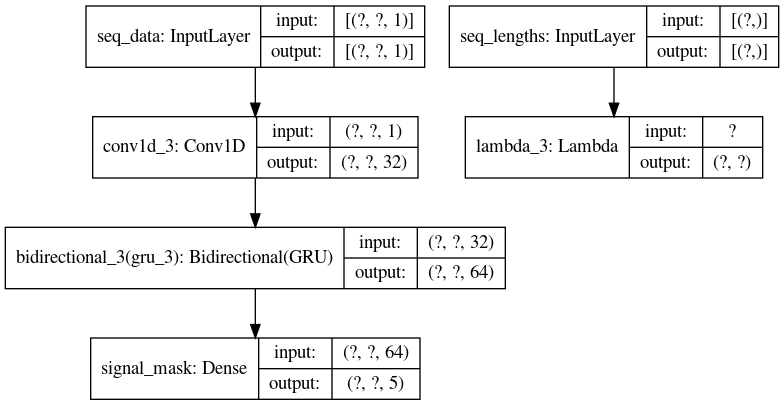

In [11]:
def model1():
    seq_data = keras.Input(shape=(None, 1),  name="seq_data")
    seq_lengths = keras.Input(shape=(), name="seq_lengths", dtype=tf.int32)

    mask = keras.layers.Lambda(lambda x: tf.sequence_mask(x))(seq_lengths)
    conv = layers.Conv1D(32, 3, strides=1, padding='same', activation='relu')(seq_data)
    rnn = layers.Bidirectional(layers.GRU(32, return_sequences=True))(conv,mask=mask)
    #rnn = layers.Bidirectional(layers.GRU(32, return_sequences=True))(conv)
    dense = layers.Dense(5, name="signal_mask")(rnn)
    model = keras.Model(inputs=[seq_data, seq_lengths], outputs=[dense])

    model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.001),
            loss=tf.keras.backend.sparse_categorical_crossentropy)
    
    return model
    
model1 = model1()
    
print(model1.summary())
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model1, to_file=dot_img_file, show_shapes=True)

In [12]:
batch_size = 1
time_step = 1000
signal_length = 1000
sequences = np.random.rand(batch_size, time_step, 1)
seq_lengths = np.array([signal_length]*batch_size)
signal_mask = np.random.randint(5, size=(batch_size, time_step))

    
dataset = tf.data.Dataset.from_tensor_slices(((sequences, seq_lengths),  signal_mask)).repeat(10).batch(1)


model1.fit(dataset, epochs=1)

Train on 10 steps


InvalidArgumentError: Node 'training/Adam/gradients/gradients/bidirectional_3/forward_gru_3_1/while_grad/bidirectional_3/forward_gru_3_1/while_grad': Connecting to invalid output 64 of source node bidirectional_3/forward_gru_3_1/while which has 64 outputs. Try using tf.compat.v1.experimental.output_all_intermediates(True).

In [ ]:
batch_size = 1
time_step = 6
signal_length = 6
sequences = np.random.rand(batch_size, time_step, 1)
seq_lengths = np.array([signal_length]*batch_size)
signal_mask = np.random.randint(5, size=(batch_size, time_step))

    
dataset = tf.data.Dataset.from_tensor_slices(((sequences, seq_lengths),  signal_mask)).repeat(10).batch(2)
batch = next(iter(dataset))
batch

In [ ]:
%%writefile config.yaml
trainingInput:
  scaleTier: CUSTOM
  # Configure a master worker with 1 with K80 GPUs
  masterType: n1-highcpu-16
  masterConfig:
    acceleratorConfig:
      count: 2
      type: NVIDIA_TESLA_K80
  # Configure 1 worker(s), each with 2 K80
  workerCount: 1
  workerType: n1-highcpu-16
  workerConfig:
    acceleratorConfig:
      count: 2
      type: NVIDIA_TESLA_K80

In [ ]:
%%bash

now=$(date +"%Y%m%d_%H%M%S")
JOB_NAME="multi_cpu_fashion_minst_$now"

gcloud ai-platform jobs submit training $JOB_NAME \
  --staging-bucket=gs://mlops-dev-workspace \
  --package-path=sample \
  --module-name=sample.model \
  --runtime-version=2.1 \
  --python-version=3.7 \
  --region=us-west1 \
  --config config.yaml
  

In [ ]:
!gcloud ai-platform jobs stream-logs multi_cpu_fashion_minst_20200805_040150